# Setup
1. In colab: Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU"
2. Install TerraTorch

In [1]:
!pip install terratorch==1.1.1 gdown tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of rioxarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of lightning[pytorch-extra] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.3/560.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/2

In [1]:
import os
import sys
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


3. Download the dataset from Google Drive

In [2]:
if not os.path.isfile('hls_burn_scars.tar.gz'):
    gdown.download("https://drive.google.com/uc?id=1yFDNlGqGPxkc9lh9l1O70TuejXAQYYtC")

if not os.path.isdir('hls_burn_scars/'):
    !tar -xzvf hls_burn_scars.tar.gz &


Downloading...
From (original): https://drive.google.com/uc?id=1yFDNlGqGPxkc9lh9l1O70TuejXAQYYtC
From (redirected): https://drive.google.com/uc?id=1yFDNlGqGPxkc9lh9l1O70TuejXAQYYtC&confirm=t&uuid=65cd97f7-e2de-42c6-b98c-66d67c64da75
To: /content/hls_burn_scars.tar.gz
100%|██████████| 2.65G/2.65G [00:39<00:00, 67.9MB/s]


._hls_burn_scars
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
hls_burn_scars/
hls_burn_scars/._.DS_Store
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
hls_burn_scars/.DS_Store
hls_burn_scars/._data
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
hls_burn_scars/data/
hls_burn_scars/splits/
hls_burn_scars/splits/._train.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemDownloadedDate'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
hls_burn_scars/splits/train.txt
hls_burn_

## HLS Burn Scars Dataset

Lets start with analyzing the dataset

In [3]:
dataset_path = Path('hls_burn_scars')
!ls "hls_burn_scars/"

data  splits


In [4]:
!ls "hls_burn_scars/data/" | head

subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018280.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018280.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2019305.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2019305.v1.4_merged.tif


In [5]:
datamodule = terratorch.datamodules.GenericNonGeoSegmentationDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=2,

    # Define dataset paths
    train_data_root=dataset_path / 'data/',
    train_label_data_root=dataset_path / 'data/',
    val_data_root=dataset_path / 'data/',
    val_label_data_root=dataset_path / 'data/',
    test_data_root=dataset_path / 'data/',
    test_label_data_root=dataset_path / 'data/',

    # Define splits
    train_split=dataset_path / 'splits/train.txt',
    val_split=dataset_path / 'splits/val.txt',
    test_split=dataset_path / 'splits/test.txt',

    img_grep='*_merged.tif',
    label_grep='*.mask.tif',

    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,

    # Define standardization values
    means=[
      0.0333497067415863,
      0.0570118552053618,
      0.0588974813200132,
      0.2323245113436119,
      0.1972854853760658,
      0.1194491422518656,
    ],
    stds=[
      0.0226913556882377,
      0.0268075602230702,
      0.0400410984436278,
      0.0779173242367269,
      0.0870873883814014,
      0.0724197947743781,
    ],
    no_data_replace=0,
    no_label_replace=-1,
    # We use all six bands of the data, so we don't need to define dataset_bands and output_bands.
)

# Setup train and val datasets
datamodule.setup("fit")

In [6]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

524

In [7]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

160

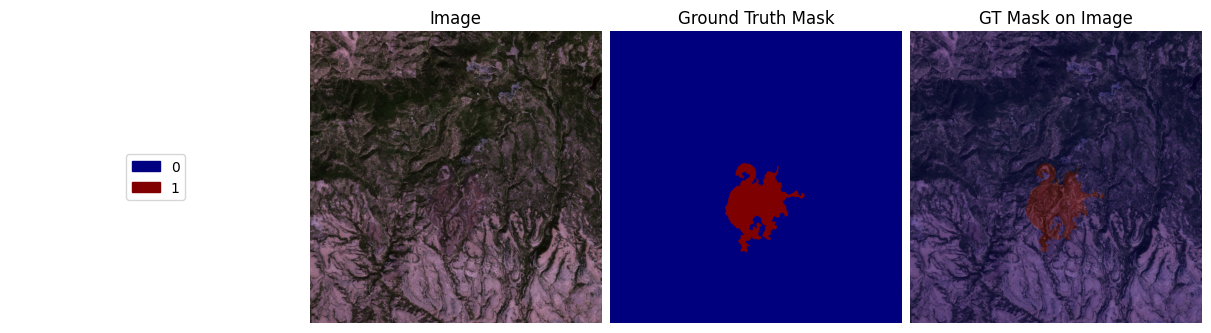

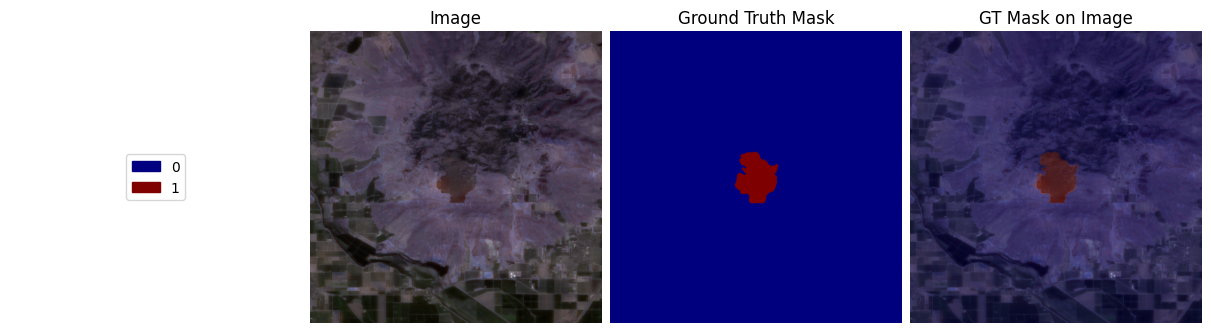

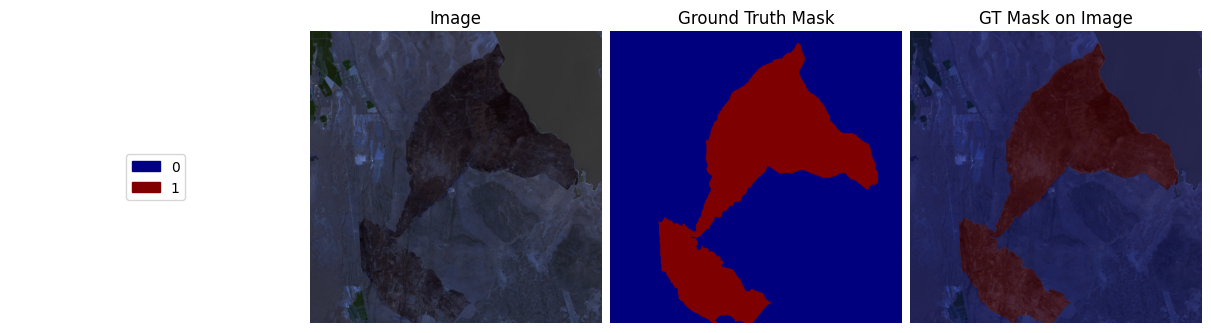

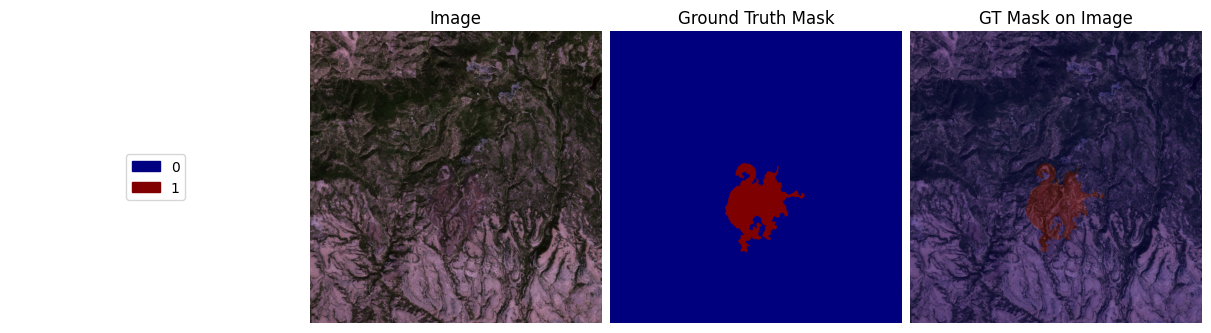

In [8]:
# plotting a few samples
val_dataset.plot(val_dataset[0])
val_dataset.plot(val_dataset[6])
val_dataset.plot(val_dataset[10])

In [9]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

120

# Fine-tune Prithvi

In [10]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/burnscars/checkpoints/",
    mode="max",
    monitor="val/F1_Score", # Variable to monitor
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/burnscars",
    detect_anomaly=True,
)

# Model
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_pretrained": True,
        "backbone_num_frames": 1, # 1 is the default value,
        "backbone_img_size": 512,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        # "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {"name": "ReshapeTokensToImage",},
            {"name": "LearnedInterpolateToPyramidal"}
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],

        # Head
        "head_dropout": 0.1,
        "num_classes": 2,
    },

    loss="ce",
    optimizer="AdamW",
    lr=1e-4,
    ignore_index=-1,
    freeze_backbone=True, # Only to speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=['no burned', 'burned']  # optionally define class names
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Prithvi_EO_V2_300M.pt:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [11]:
# Training
trainer.fit(model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │  324 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 20.3 M                                                                                           
Non-trainable params: 303 M                                                                                        
Total params: 324 M                                                                                                
Total estimated model params size (MB): 1.3 K                                                                      
Modules in train mode: 647                                                                                         
Modules in eval mode: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [12]:
best_ckpt_path = "output/burnscars/checkpoints/best-epoch=00.ckpt"

In [13]:
def run_test_and_visual_inspection(model,ckpt_path):

    # let's run the model on the test set
    trainer.test(model, datamodule=datamodule, ckpt_path=ckpt_path)

    # now we can use the model for predictions and plotting!
    model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
        ckpt_path,
        model_factory=model.hparams.model_factory,
        model_args=model.hparams.model_args,
    )

    test_loader = datamodule.test_dataloader()

    with torch.no_grad():
        batch = next(iter(test_loader))
        images = datamodule.aug(batch)
        images = batch["image"].to(model.device)
        masks = batch["mask"].numpy()

        outputs = model(images)
        preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

    for i in range(4):
        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[i]
        sample["image"] = sample["image"].cpu()
        sample["mask"] = sample["mask"].cpu()
        test_dataset.plot(sample)

INFO: Restoring states from the checkpoint path at output/burnscars/checkpoints/best-epoch=00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at output/burnscars/checkpoints/best-epoch=00.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at output/burnscars/checkpoints/best-epoch=00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at output/burnscars/checkpoints/best-epoch=00.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/Accuracy         │      0.8653072714805603       │
│      test/Boundary_mIoU       │      0.09175211936235428      │
│  test/Class_Accuracy_burned   │      0.7535651922225952       │
│ test/Class_Accuracy_no burned │      0.9770493507385254       │
│         test/F1_Score         │      0.8734312057495117       │
│        test/IoU_burned        │      0.6294723153114319       │
│      test/IoU_no burned       │      0.9497997164726257       │
│      test/Pixel_Accuracy      │      0.9537445306777954       │
│           test/loss           │      0.20308290421962738      │
│           test/mIoU           │      0.7896360158920288       │
│        test/mIoU_Micro        │      0.9115790128707886       │
└───────────────────────────────┴───────────────────────────────┘

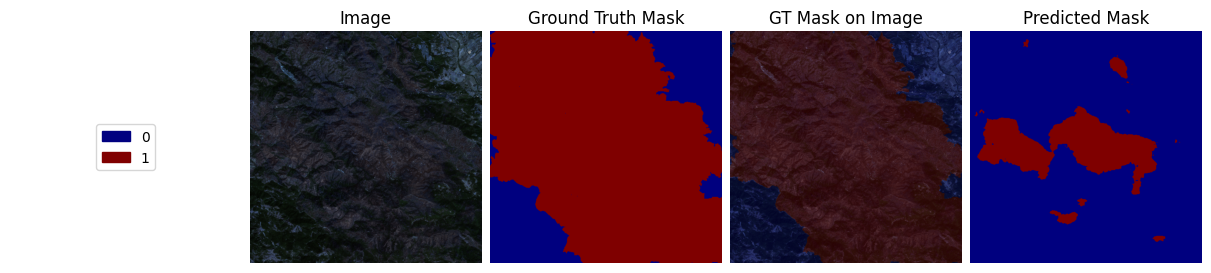

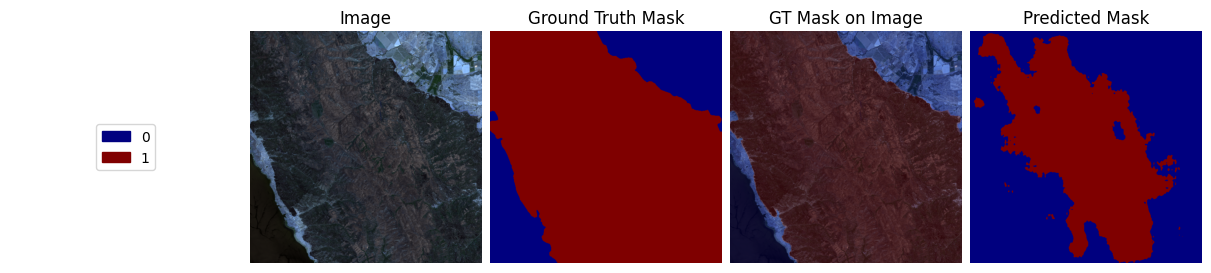

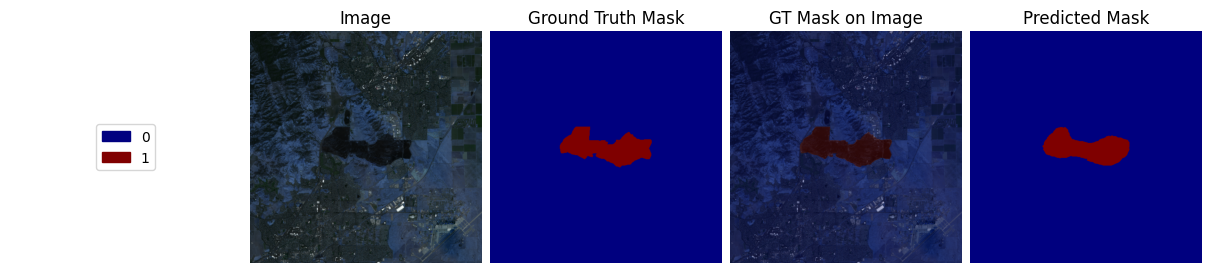

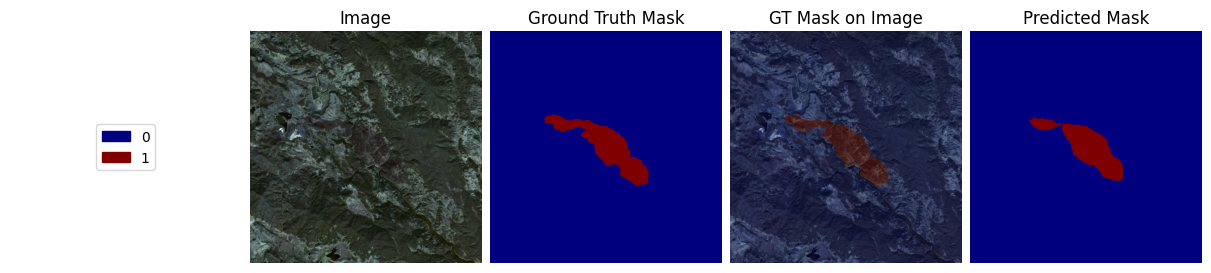

In [14]:
run_test_and_visual_inspection(model, best_ckpt_path)

In [15]:
best_ckpt_100_epoch_path = "burnscars_best-epoch=69.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1-I_DiiO2T1mjBTi3OAJaVeRWKHtAG63N")


Downloading...
From (original): https://drive.google.com/uc?id=1-I_DiiO2T1mjBTi3OAJaVeRWKHtAG63N
From (redirected): https://drive.google.com/uc?id=1-I_DiiO2T1mjBTi3OAJaVeRWKHtAG63N&confirm=t&uuid=e105d2c5-7e77-4963-b35c-412eb1a0aa69
To: /content/burnscars_best-epoch=69.ckpt
100%|██████████| 1.46G/1.46G [00:27<00:00, 53.6MB/s]


INFO: Restoring states from the checkpoint path at burnscars_best-epoch=69.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at burnscars_best-epoch=69.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at burnscars_best-epoch=69.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at burnscars_best-epoch=69.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/Accuracy         │      0.9348608255386353       │
│      test/Boundary_mIoU       │       0.333344429731369       │
│  test/Class_Accuracy_burned   │      0.8771804571151733       │
│ test/Class_Accuracy_no burned │      0.9925411343574524       │
│         test/F1_Score         │      0.9464430809020996       │
│        test/IoU_burned        │       0.824364423751831       │
│      test/IoU_no burned       │      0.9785493016242981       │
│      test/Pixel_Accuracy      │      0.9805113673210144       │
│           test/loss           │      0.05975320562720299      │
│           test/mIoU           │      0.9014568328857422       │
│        test/mIoU_Micro        │      0.9617679119110107       │
└───────────────────────────────┴───────────────────────────────┘

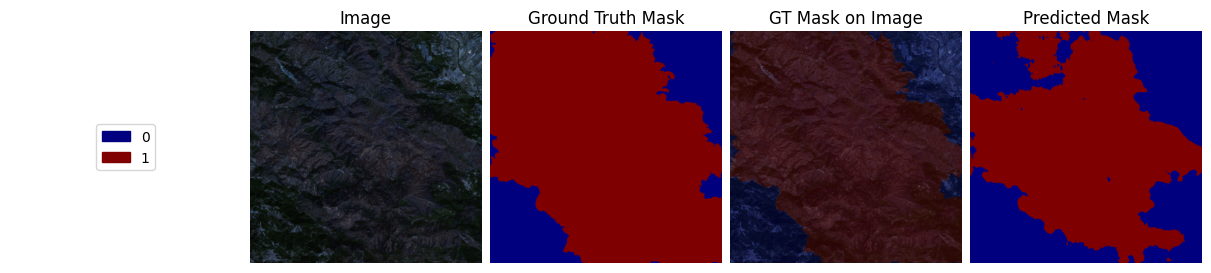

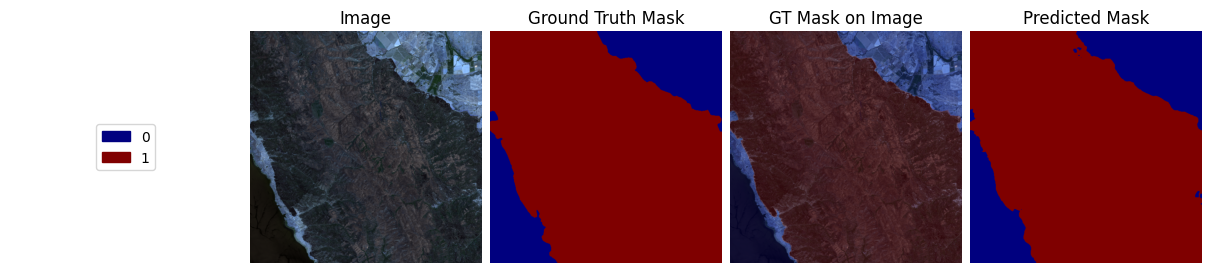

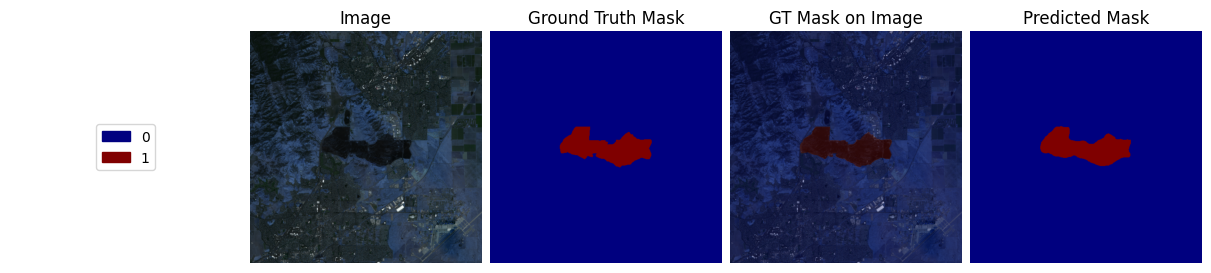

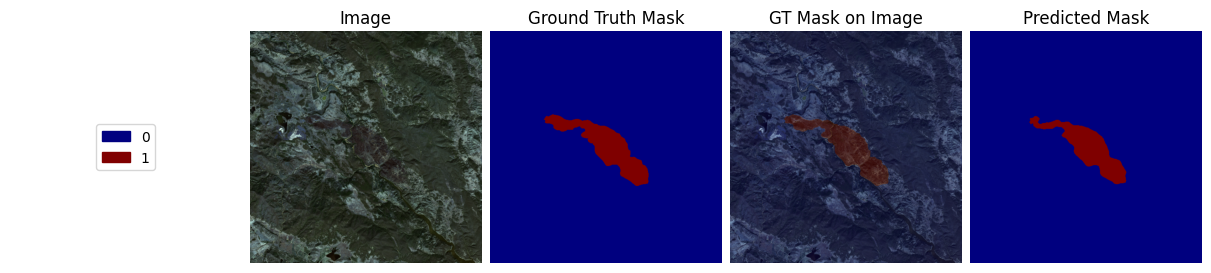

In [16]:
run_test_and_visual_inspection(model, best_ckpt_100_epoch_path)

In [1]:
!wget https://raw.githubusercontent.com/Joao-L-S-Almeida/tutorial_neurips/refs/heads/main/notebooks/prithvi_v2_eo_300_tl_unet_burnscars.yaml



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://raw.githubusercontent.]87Saving 'prithvi_v2_eo_300_tl_unet_burnscars.yaml.1'
87prithvi_v2_eo_300_tl 100% [=============================>]    1.15K    --.-KB/s87HTTP response 200  [https://raw.githubusercontent.com/Joao-L-S-Almeida/tutorial_neurips/refs/heads/main/notebooks/prithvi_v2_eo_300_tl_unet_burnscars.yaml]
87prithvi_v2_eo_300_tl 100% [=============================>]    1.15K    --.-KB/s87[Files: 1  Bytes: 1.15K [1.83KB]8

# Fine-tuning via CLI

You might want to restart the session to free up GPU memory.

In [2]:
# Run fine-tuning
!terratorch fit -c prithvi_v2_eo_300_tl_unet_burnscars.yaml

Traceback (most recent call last):
  File "/home/jalmeida/envs/dev/bin/terratorch", line 5, in <module>
    from terratorch.__main__ import main
  File "/home/jalmeida/envs/dev/lib64/python3.13/site-packages/terratorch/__init__.py", line 7, in <module>
    import terratorch.models  # noqa: F401
    ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jalmeida/envs/dev/lib64/python3.13/site-packages/terratorch/models/__init__.py", line 6, in <module>
    import terratorch.models.necks  # register necks  # noqa: F401
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jalmeida/envs/dev/lib64/python3.13/site-packages/terratorch/models/necks.py", line 14, in <module>
    from terratorch.registry import NECK_REGISTRY, TERRATORCH_NECK_REGISTRY
  File "/home/jalmeida/envs/dev/lib64/python3.13/site-packages/terratorch/registry/__init__.py", line 15, in <module>
    import terratorch.registry.smp_registry  # register smp registry
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jalmeida/envs/dev/lib64/